In [1]:
!pip install sparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 14.2 MB/s eta 0:00:00


In [2]:
!pip install gigafile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.3 MB/s eta 0:00:00


In [3]:
!gfile download https://86.gigafile.nu/0108-jed3fb1e87c0186233c113f4f60382786

Name: heatmap_dataset.zip, size: 3.63GB, id: 0108-jed3fb1e87c0186233c113f4f60382786
heatmap_dataset.zip: 100% 3.63G/3.63G [09:15<00:00, 7.01MB/s]
Filesize check: expected: 3893227091; actual: 3893227091
Succeeded.


In [4]:
!unzip heatmap_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0263_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0264_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0265_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0266_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0267_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0268_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0269_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0270_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0271_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0272_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0273_person_1.npz  
  inflating: Heatmap_Dataset/shop_lifter_n_92/id_1/j_frame_0274_person_1.n

In [5]:
import os
import torch.nn as nn
import numpy as np
import torch
import importlib.util
import math
import torch.nn.functional as F
from typing import Any, Dict, List, Tuple, Optional

from torch.utils.data import Dataset, DataLoader, random_split
import sparse
from sklearn.model_selection import train_test_split

In [6]:

class SimpleHead(nn.Module):
    """ A simplified classification head.

    Args:
        num_classes (int): Number of classes to be classified.
        in_channels (int): Number of channels in input features.
        dropout (float): Probability of dropout layer. Default: 0.5.
        init_std (float): Std value for weight initialization. Default: 0.01.
        mode (str): Determines the pooling mode ('3D', 'GCN', or '2D').
    """

    def __init__(self,
                 num_classes,
                 in_channels,
                 dropout=0.5,
                 init_std=0.01,
                 mode='3D'):
        super(SimpleHead, self).__init__()

        self.dropout_ratio = dropout
        self.init_std = init_std
        self.mode = mode

        if self.dropout_ratio != 0:
            self.dropout = nn.Dropout(p=self.dropout_ratio)
        else:
            self.dropout = None

        self.in_c = in_channels
        self.fc_cls = nn.Linear(self.in_c, num_classes)

        # Initialize weights of the final fully connected layer
        self.init_weights()

    def init_weights(self):
        """Initialize the weights of the classification layer."""
        nn.init.normal_(self.fc_cls.weight, 0, self.init_std)
        if self.fc_cls.bias is not None:
            nn.init.constant_(self.fc_cls.bias, 0)

    def forward(self, x):
        """Defines the forward computation.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: Classification scores.
        """
        if isinstance(x, list):
            # Case where x is a list of tensors, reduce each to its mean along dim 0
            x = [item.mean(dim=0) for item in x]
            x = torch.stack(x)

        if len(x.shape) != 2:
            # 2D, 3D, or GCN mode with different types of pooling
            if self.mode == '2D':
                N, S, C, H, W = x.shape
                x = x.view(N * S, C, H, W)
                x = nn.AdaptiveAvgPool2d(1)(x)
                x = x.view(N, S, C).mean(dim=1)
            elif self.mode == '3D':
                x = nn.AdaptiveAvgPool3d(1)(x)
                x = x.view(x.shape[:2])  # Collapse spatial dimensions to get (N, C)
            elif self.mode == 'GCN':
                N, M, C, T, V = x.shape
                x = x.view(N * M, C, T, V)
                x = nn.AdaptiveAvgPool2d(1)(x)
                x = x.view(N, M, C).mean(dim=1)

        if self.dropout is not None:
            x = self.dropout(x)

        # Compute class scores
        cls_score = self.fc_cls(x)
        return cls_score

class I3DHead(SimpleHead):
    """I3D Head inheriting from SimpleHead for 3D mode."""
    def __init__(self, num_classes, in_channels, dropout=0.5, init_std=0.01):
        super(I3DHead, self).__init__(num_classes, in_channels, dropout=dropout, init_std=init_std, mode='3D')

class GCNHead(SimpleHead):
    """GCN Head inheriting from SimpleHead for GCN mode."""
    def __init__(self, num_classes, in_channels, dropout=0., init_std=0.01):
        super(GCNHead, self).__init__(num_classes, in_channels, dropout=dropout, init_std=init_std, mode='GCN')

class TSNHead(SimpleHead):
    """TSN Head inheriting from SimpleHead for 2D mode."""
    def __init__(self, num_classes, in_channels, dropout=0.5, init_std=0.01):
        super(TSNHead, self).__init__(num_classes, in_channels, dropout=dropout, init_std=init_std, mode='2D')

class SlowFastHead(I3DHead):
    """SlowFast Head inheriting from I3DHead."""
    pass

class Recognizer3D(nn.Module):
    def __init__(self, backbone, cls_head, test_cfg=None):
        super(Recognizer3D, self).__init__()
        self.backbone = backbone
        self.cls_head = cls_head
        self.test_cfg = test_cfg

    def forward(self, x):
        x = self.backbone(x)
        x = self.cls_head(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True, norm=True, activation=True):
        super(ConvBlock, self).__init__()

        layers = []

        # Convolution layer
        layers.append(
            nn.Conv3d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups, bias=bias
            )
        )

        # Optional normalization layer (BatchNorm3d)
        if norm:
            layers.append(nn.BatchNorm3d(out_channels))

        # Optional activation layer (ReLU)
        if activation:
            layers.append(nn.ReLU(inplace=True))

        # Combine layers into a sequential block
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class C3D(nn.Module):
    """C3D backbone, without flatten and mlp.

    Args:
        pretrained (str | None): Name of pretrained model.
    """

    def __init__(self,
                 in_channels=3,
                 base_channels=64,
                 num_stages=4,
                 temporal_downsample=True,
                 pretrained=None):
        super().__init__()

        self.pretrained = pretrained
        self.in_channels = in_channels
        self.base_channels = base_channels
        assert num_stages in [3, 4]
        self.num_stages = num_stages
        self.temporal_downsample = temporal_downsample

        pool_kernel, pool_stride = 2, 2
        if not self.temporal_downsample:
            pool_kernel, pool_stride = (1, 2, 2), (1, 2, 2)

        # C3D convolution parameters
        c3d_conv_param = dict(kernel_size=3, padding=1)

        # Define the convolutional layers using the simplified ConvBlock
        self.conv1a = ConvBlock(self.in_channels, self.base_channels, **c3d_conv_param)
        self.pool1 = nn.AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2a = ConvBlock(self.base_channels, self.base_channels * 2, **c3d_conv_param)
        self.pool2 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)

        self.conv3a = ConvBlock(self.base_channels * 2, self.base_channels * 4, **c3d_conv_param)
        self.conv3b = ConvBlock(self.base_channels * 4, self.base_channels * 4, **c3d_conv_param)
        self.pool3 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)

        self.conv4a = ConvBlock(self.base_channels * 4, self.base_channels * 8, **c3d_conv_param)
        self.conv4b = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)

        if self.num_stages == 4:
            self.pool4 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)
            self.conv5a = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)
            self.conv5b = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)

    def init_weights(self):
        """Initiate the parameters either from existing checkpoint or from scratch."""
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Defines the computation performed at every call.

        Args:
            x (torch.Tensor): The input data. The size of x is (num_batches, 3, 16, 112, 112).

        Returns:
            torch.Tensor: The feature of the input samples extracted by the backbone.
        """
        x = self.conv1a(x)
        x = self.pool1(x)

        x = self.conv2a(x)
        x = self.pool2(x)

        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = self.conv4b(x)

        if self.num_stages == 3:
            return x

        x = self.pool4(x)
        x = self.conv5a(x)
        x = self.conv5b(x)

        return x





class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.bottleneck = self._round_width(channels, reduction)
        self.fc1 = nn.Conv3d(channels, self.bottleneck, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv3d(self.bottleneck, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    @staticmethod
    def _round_width(width, multiplier, min_width=8, divisor=8):
        width *= multiplier
        width_out = max(min_width, int(width + divisor / 2) // divisor * divisor)
        if width_out < 0.9 * width:
            width_out += divisor
        return int(width_out)

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class BlockX3D(nn.Module):
    """BlockX3D 3D building block for X3D.

    Args:
        inplanes (int): Number of channels for the input in the first ConvBlock.
        planes (int): Number of channels produced by intermediate ConvBlock layers.
        outplanes (int): Number of channels produced by the final ConvBlock layer.
        spatial_stride (int): Spatial stride in the ConvBlock layer. Default: 1.
        downsample (nn.Module | None): Downsample layer. Default: None.
        se_ratio (float | None): The reduction ratio of squeeze and excitation unit.
            If set as None, it means not using SE unit. Default: None.
        use_swish (bool): Whether to use Swish as the activation function
            before and after the 3x3x3 conv. Default: True.
    """

    def __init__(self,
                 inplanes,
                 planes,
                 outplanes,
                 spatial_stride=1,
                 downsample=None,
                 se_ratio=None,
                 use_swish=True):
        super().__init__()

        self.inplanes = inplanes
        self.planes = planes
        self.outplanes = outplanes
        self.spatial_stride = spatial_stride
        self.downsample = downsample
        self.se_ratio = se_ratio
        self.use_swish = use_swish

        # First ConvBlock (1x1x1 Conv)
        self.conv1 = ConvBlock(
            in_channels=inplanes,
            out_channels=planes,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=True)  # ReLU activation

        # Second ConvBlock (3x3x3 Depthwise Conv)
        self.conv2 = ConvBlock(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=(1, self.spatial_stride, self.spatial_stride),
            padding=1,
            groups=planes,  # Depthwise convolution
            bias=False,
            norm=True,
            activation=False)  # No activation here, as Swish is applied later

        # Swish activation (or Identity if not used)
        self.swish = Swish() if self.use_swish else nn.Identity()

        # Third ConvBlock (1x1x1 Conv, no activation)
        self.conv3 = ConvBlock(
            in_channels=planes,
            out_channels=outplanes,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=False)  # No activation after this layer

        # Squeeze-and-Excitation (SE) module if se_ratio is provided
        if self.se_ratio is not None:
            self.se_module = SEModule(planes, self.se_ratio)

        # Final ReLU activation
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """Defines the computation performed at every call."""

        identity = x

        # First ConvBlock
        out = self.conv1(x)

        # Second ConvBlock (Depthwise Conv)
        out = self.conv2(out)

        # Apply SE module if defined
        if self.se_ratio is not None:
            out = self.se_module(out)

        # Apply Swish (or Identity if Swish is not used)
        out = self.swish(out)

        # Third ConvBlock
        out = self.conv3(out)

        # Apply downsampling if defined
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the residual (identity) connection
        out += identity

        # Final ReLU activation
        out = self.relu(out)

        return out

class X3D(nn.Module):
    def __init__(self,
                 gamma_w=1.0,
                 gamma_b=2.25,
                 gamma_d=2.2,
                 pretrained=None,
                 in_channels=3,
                 base_channels=24,
                 num_stages=4,
                 stage_blocks=(1, 2, 5, 3),
                 spatial_strides=(2, 2, 2, 2),
                 frozen_stages=-1,
                 se_style='half',
                 se_ratio=1 / 16,
                 use_swish=True,
                 norm_eval=False,
                 zero_init_residual=True,
                 **kwargs):
        super().__init__()
        self.gamma_w = gamma_w
        self.gamma_b = gamma_b
        self.gamma_d = gamma_d
        self.pretrained = pretrained
        self.in_channels = in_channels
        self.base_channels = base_channels
        self.stage_blocks = stage_blocks

        # Apply parameters gamma_w and gamma_d
        self.base_channels = self._round_width(self.base_channels, self.gamma_w)
        self.stage_blocks = [self._round_repeats(x, self.gamma_d) for x in self.stage_blocks]

        self.num_stages = num_stages
        assert 1 <= num_stages <= 4
        self.spatial_strides = spatial_strides
        assert len(spatial_strides) == num_stages
        self.frozen_stages = frozen_stages
        self.se_style = se_style
        self.se_ratio = se_ratio
        self.use_swish = use_swish
        self.norm_eval = norm_eval
        self.zero_init_residual = zero_init_residual

        self.block = BlockX3D
        self.stage_blocks = self.stage_blocks[:num_stages]
        self.layer_inplanes = self.base_channels
        self._make_stem_layer()

        self.res_layers = []
        for i, num_blocks in enumerate(self.stage_blocks):
            spatial_stride = spatial_strides[i]
            inplanes = self.base_channels * 2**i
            planes = int(inplanes * self.gamma_b)

            res_layer = self.make_res_layer(
                self.block,
                self.layer_inplanes,
                inplanes,
                planes,
                num_blocks,
                spatial_stride=spatial_stride,
                se_style=self.se_style,
                se_ratio=self.se_ratio,
                use_swish=self.use_swish,
                **kwargs)
            self.layer_inplanes = inplanes
            layer_name = f'layer{i + 1}'
            self.add_module(layer_name, res_layer)
            self.res_layers.append(layer_name)

        self.feat_dim = self.base_channels * 2**(len(self.stage_blocks) - 1)
        self.conv5 = ConvBlock(
            self.feat_dim,
            int(self.feat_dim * self.gamma_b),
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=True)
        self.feat_dim = int(self.feat_dim * self.gamma_b)

    @staticmethod
    def _round_width(width, multiplier, min_depth=8, divisor=8):
        if not multiplier:
            return width
        width *= multiplier
        min_depth = min_depth or divisor
        new_filters = max(min_depth, int(width + divisor / 2) // divisor * divisor)
        if new_filters < 0.9 * width:
            new_filters += divisor
        return int(new_filters)

    @staticmethod
    def _round_repeats(repeats, multiplier):
        if not multiplier:
            return repeats
        return int(math.ceil(multiplier * repeats))

    def _make_stem_layer(self):
        self.conv1_s = ConvBlock(
            self.in_channels,
            self.base_channels,
            kernel_size=(1, 3, 3),
            stride=(1, 2, 2),
            padding=(0, 1, 1),
            bias=False,
            norm=False,
            activation=False)
        self.conv1_t = ConvBlock(
            self.base_channels,
            self.base_channels,
            kernel_size=(5, 1, 1),
            stride=(1, 1, 1),
            padding=(2, 0, 0),
            groups=self.base_channels,
            bias=False,
            norm=True,
            activation=True)

    def make_res_layer(self,
                       block,
                       layer_inplanes,
                       inplanes,
                       planes,
                       blocks,
                       spatial_stride=1,
                       se_style='half',
                       se_ratio=None,
                       use_swish=True,
                       **kwargs):
        downsample = None
        if spatial_stride != 1 or layer_inplanes != inplanes:
            downsample = ConvBlock(
                layer_inplanes,
                inplanes,
                kernel_size=1,
                stride=(1, spatial_stride, spatial_stride),
                padding=0,
                bias=False,
                norm=True,
                activation=False)

        use_se = [False] * blocks
        if self.se_style == 'all':
            use_se = [True] * blocks
        elif self.se_style == 'half':
            use_se = [i % 2 == 0 for i in range(blocks)]
        else:
            raise NotImplementedError

        layers = []
        layers.append(
            block(
                layer_inplanes,
                planes,
                inplanes,
                spatial_stride=spatial_stride,
                downsample=downsample,
                se_ratio=se_ratio if use_se[0] else None,
                use_swish=use_swish,
                **kwargs))

        for i in range(1, blocks):
            layers.append(
                block(
                    inplanes,
                    planes,
                    inplanes,
                    spatial_stride=1,
                    se_ratio=se_ratio if use_se[i] else None,
                    use_swish=use_swish,
                    **kwargs))

        return nn.Sequential(*layers)

    def _freeze_stages(self):
        """Prevent all the parameters from being optimized before
        ``self.frozen_stages``."""
        if self.frozen_stages >= 0:
            # Freeze the stem layers (conv1_s and conv1_t)
            self.conv1_s.eval()
            self.conv1_t.eval()
            for param in self.conv1_s.parameters():
                param.requires_grad = False
            for param in self.conv1_t.parameters():
                param.requires_grad = False

        # Freeze the stages based on the frozen_stages parameter
        for i in range(1, self.frozen_stages + 1):
            res_layer = getattr(self, f'layer{i}')
            res_layer.eval()  # Set the layer to evaluation mode
            for param in res_layer.parameters():
                param.requires_grad = False


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, BlockX3D):
                    nn.init.constant_(m.conv3.bn.weight, 0)

        if isinstance(self.pretrained, str):
            self.load_state_dict(torch.load(self.pretrained))

    def forward(self, x):
        x = self.conv1_s(x)
        x = self.conv1_t(x)
        for layer_name in self.res_layers:
            res_layer = getattr(self, layer_name)
            x = res_layer(x)
        x = self.conv5(x)
        return x

    def train(self, mode=True):
        super(X3D, self).train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                if isinstance(m, nn.BatchNorm3d):
                    m.eval()

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True, norm=True, activation=True):
        super(ConvBlock, self).__init__()

        layers = []

        # Convolution layer
        layers.append(
            nn.Conv3d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups, bias=bias
            )
        )

        # Optional normalization layer (BatchNorm3d)
        if norm:
            layers.append(nn.BatchNorm3d(out_channels))

        # Optional activation layer (ReLU)
        if activation:
            layers.append(nn.ReLU(inplace=True))

        # Combine layers into a sequential block
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class C3D(nn.Module):
    """C3D backbone, without flatten and mlp.

    Args:
        pretrained (str | None): Name of pretrained model.
    """

    def __init__(self,
                 in_channels=3,
                 base_channels=64,
                 num_stages=4,
                 temporal_downsample=True,
                 pretrained=None):
        super().__init__()

        self.pretrained = pretrained
        self.in_channels = in_channels
        self.base_channels = base_channels
        assert num_stages in [3, 4]
        self.num_stages = num_stages
        self.temporal_downsample = temporal_downsample

        pool_kernel, pool_stride = 2, 2
        if not self.temporal_downsample:
            pool_kernel, pool_stride = (1, 2, 2), (1, 2, 2)

        # C3D convolution parameters
        c3d_conv_param = dict(kernel_size=3, padding=1)

        # Define the convolutional layers using the simplified ConvBlock
        self.conv1a = ConvBlock(self.in_channels, self.base_channels, **c3d_conv_param)
        self.pool1 = nn.AvgPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2a = ConvBlock(self.base_channels, self.base_channels * 2, **c3d_conv_param)
        self.pool2 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)

        self.conv3a = ConvBlock(self.base_channels * 2, self.base_channels * 4, **c3d_conv_param)
        self.conv3b = ConvBlock(self.base_channels * 4, self.base_channels * 4, **c3d_conv_param)
        self.pool3 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)

        self.conv4a = ConvBlock(self.base_channels * 4, self.base_channels * 8, **c3d_conv_param)
        self.conv4b = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)

        if self.num_stages == 4:
            self.pool4 = nn.AvgPool3d(kernel_size=pool_kernel, stride=pool_stride)
            self.conv5a = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)
            self.conv5b = ConvBlock(self.base_channels * 8, self.base_channels * 8, **c3d_conv_param)

    def init_weights(self):
        """Initiate the parameters either from existing checkpoint or from scratch."""
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Defines the computation performed at every call.

        Args:
            x (torch.Tensor): The input data. The size of x is (num_batches, 3, 16, 112, 112).

        Returns:
            torch.Tensor: The feature of the input samples extracted by the backbone.
        """
        x = self.conv1a(x)
        x = self.pool1(x)

        x = self.conv2a(x)
        x = self.pool2(x)

        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = self.conv4b(x)

        if self.num_stages == 3:
            return x

        x = self.pool4(x)
        x = self.conv5a(x)
        x = self.conv5b(x)

        return x





class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.bottleneck = self._round_width(channels, reduction)
        self.fc1 = nn.Conv3d(channels, self.bottleneck, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv3d(self.bottleneck, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    @staticmethod
    def _round_width(width, multiplier, min_width=8, divisor=8):
        width *= multiplier
        width_out = max(min_width, int(width + divisor / 2) // divisor * divisor)
        if width_out < 0.9 * width:
            width_out += divisor
        return int(width_out)

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class BlockX3D(nn.Module):
    """BlockX3D 3D building block for X3D.

    Args:
        inplanes (int): Number of channels for the input in the first ConvBlock.
        planes (int): Number of channels produced by intermediate ConvBlock layers.
        outplanes (int): Number of channels produced by the final ConvBlock layer.
        spatial_stride (int): Spatial stride in the ConvBlock layer. Default: 1.
        downsample (nn.Module | None): Downsample layer. Default: None.
        se_ratio (float | None): The reduction ratio of squeeze and excitation unit.
            If set as None, it means not using SE unit. Default: None.
        use_swish (bool): Whether to use Swish as the activation function
            before and after the 3x3x3 conv. Default: True.
    """

    def __init__(self,
                 inplanes,
                 planes,
                 outplanes,
                 spatial_stride=1,
                 downsample=None,
                 se_ratio=None,
                 use_swish=True):
        super().__init__()

        self.inplanes = inplanes
        self.planes = planes
        self.outplanes = outplanes
        self.spatial_stride = spatial_stride
        self.downsample = downsample
        self.se_ratio = se_ratio
        self.use_swish = use_swish

        # First ConvBlock (1x1x1 Conv)
        self.conv1 = ConvBlock(
            in_channels=inplanes,
            out_channels=planes,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=True)  # ReLU activation

        # Second ConvBlock (3x3x3 Depthwise Conv)
        self.conv2 = ConvBlock(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=(1, self.spatial_stride, self.spatial_stride),
            padding=1,
            groups=planes,  # Depthwise convolution
            bias=False,
            norm=True,
            activation=False)  # No activation here, as Swish is applied later

        # Swish activation (or Identity if not used)
        self.swish = Swish() if self.use_swish else nn.Identity()

        # Third ConvBlock (1x1x1 Conv, no activation)
        self.conv3 = ConvBlock(
            in_channels=planes,
            out_channels=outplanes,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=False)  # No activation after this layer

        # Squeeze-and-Excitation (SE) module if se_ratio is provided
        if self.se_ratio is not None:
            self.se_module = SEModule(planes, self.se_ratio)

        # Final ReLU activation
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """Defines the computation performed at every call."""

        identity = x

        # First ConvBlock
        out = self.conv1(x)

        # Second ConvBlock (Depthwise Conv)
        out = self.conv2(out)

        # Apply SE module if defined
        if self.se_ratio is not None:
            out = self.se_module(out)

        # Apply Swish (or Identity if Swish is not used)
        out = self.swish(out)

        # Third ConvBlock
        out = self.conv3(out)

        # Apply downsampling if defined
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the residual (identity) connection
        out += identity

        # Final ReLU activation
        out = self.relu(out)

        return out

class X3D(nn.Module):
    def __init__(self,
                 gamma_w=1.0,
                 gamma_b=2.25,
                 gamma_d=2.2,
                 pretrained=None,
                 in_channels=3,
                 base_channels=24,
                 num_stages=4,
                 stage_blocks=(1, 2, 5, 3),
                 spatial_strides=(2, 2, 2, 2),
                 frozen_stages=-1,
                 se_style='half',
                 se_ratio=1 / 16,
                 use_swish=True,
                 norm_eval=False,
                 zero_init_residual=True,
                 **kwargs):
        super().__init__()
        self.gamma_w = gamma_w
        self.gamma_b = gamma_b
        self.gamma_d = gamma_d
        self.pretrained = pretrained
        self.in_channels = in_channels
        self.base_channels = base_channels
        self.stage_blocks = stage_blocks

        # Apply parameters gamma_w and gamma_d
        self.base_channels = self._round_width(self.base_channels, self.gamma_w)
        self.stage_blocks = [self._round_repeats(x, self.gamma_d) for x in self.stage_blocks]

        self.num_stages = num_stages
        assert 1 <= num_stages <= 4
        self.spatial_strides = spatial_strides
        assert len(spatial_strides) == num_stages
        self.frozen_stages = frozen_stages
        self.se_style = se_style
        self.se_ratio = se_ratio
        self.use_swish = use_swish
        self.norm_eval = norm_eval
        self.zero_init_residual = zero_init_residual

        self.block = BlockX3D
        self.stage_blocks = self.stage_blocks[:num_stages]
        self.layer_inplanes = self.base_channels
        self._make_stem_layer()

        self.res_layers = []
        for i, num_blocks in enumerate(self.stage_blocks):
            spatial_stride = spatial_strides[i]
            inplanes = self.base_channels * 2**i
            planes = int(inplanes * self.gamma_b)

            res_layer = self.make_res_layer(
                self.block,
                self.layer_inplanes,
                inplanes,
                planes,
                num_blocks,
                spatial_stride=spatial_stride,
                se_style=self.se_style,
                se_ratio=self.se_ratio,
                use_swish=self.use_swish,
                **kwargs)
            self.layer_inplanes = inplanes
            layer_name = f'layer{i + 1}'
            self.add_module(layer_name, res_layer)
            self.res_layers.append(layer_name)

        self.feat_dim = self.base_channels * 2**(len(self.stage_blocks) - 1)
        self.conv5 = ConvBlock(
            self.feat_dim,
            int(self.feat_dim * self.gamma_b),
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=True)
        self.feat_dim = int(self.feat_dim * self.gamma_b)

    @staticmethod
    def _round_width(width, multiplier, min_depth=8, divisor=8):
        if not multiplier:
            return width
        width *= multiplier
        min_depth = min_depth or divisor
        new_filters = max(min_depth, int(width + divisor / 2) // divisor * divisor)
        if new_filters < 0.9 * width:
            new_filters += divisor
        return int(new_filters)

    @staticmethod
    def _round_repeats(repeats, multiplier):
        if not multiplier:
            return repeats
        return int(math.ceil(multiplier * repeats))

    def _make_stem_layer(self):
        self.conv1_s = ConvBlock(
            self.in_channels,
            self.base_channels,
            kernel_size=(1, 3, 3),
            stride=(1, 2, 2),
            padding=(0, 1, 1),
            bias=False,
            norm=False,
            activation=False)
        self.conv1_t = ConvBlock(
            self.base_channels,
            self.base_channels,
            kernel_size=(5, 1, 1),
            stride=(1, 1, 1),
            padding=(2, 0, 0),
            groups=self.base_channels,
            bias=False,
            norm=True,
            activation=True)

    def make_res_layer(self,
                       block,
                       layer_inplanes,
                       inplanes,
                       planes,
                       blocks,
                       spatial_stride=1,
                       se_style='half',
                       se_ratio=None,
                       use_swish=True,
                       **kwargs):
        downsample = None
        if spatial_stride != 1 or layer_inplanes != inplanes:
            downsample = ConvBlock(
                layer_inplanes,
                inplanes,
                kernel_size=1,
                stride=(1, spatial_stride, spatial_stride),
                padding=0,
                bias=False,
                norm=True,
                activation=False)

        use_se = [False] * blocks
        if self.se_style == 'all':
            use_se = [True] * blocks
        elif self.se_style == 'half':
            use_se = [i % 2 == 0 for i in range(blocks)]
        else:
            raise NotImplementedError

        layers = []
        layers.append(
            block(
                layer_inplanes,
                planes,
                inplanes,
                spatial_stride=spatial_stride,
                downsample=downsample,
                se_ratio=se_ratio if use_se[0] else None,
                use_swish=use_swish,
                **kwargs))

        for i in range(1, blocks):
            layers.append(
                block(
                    inplanes,
                    planes,
                    inplanes,
                    spatial_stride=1,
                    se_ratio=se_ratio if use_se[i] else None,
                    use_swish=use_swish,
                    **kwargs))

        return nn.Sequential(*layers)

    def _freeze_stages(self):
        """Prevent all the parameters from being optimized before
        ``self.frozen_stages``."""
        if self.frozen_stages >= 0:
            # Freeze the stem layers (conv1_s and conv1_t)
            self.conv1_s.eval()
            self.conv1_t.eval()
            for param in self.conv1_s.parameters():
                param.requires_grad = False
            for param in self.conv1_t.parameters():
                param.requires_grad = False

        # Freeze the stages based on the frozen_stages parameter
        for i in range(1, self.frozen_stages + 1):
            res_layer = getattr(self, f'layer{i}')
            res_layer.eval()  # Set the layer to evaluation mode
            for param in res_layer.parameters():
                param.requires_grad = False


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if self.zero_init_residual:
            for m in self.modules():
                if isinstance(m, BlockX3D):
                    nn.init.constant_(m.conv3.bn.weight, 0)

        if isinstance(self.pretrained, str):
            self.load_state_dict(torch.load(self.pretrained))

    def forward(self, x):
        x = self.conv1_s(x)
        x = self.conv1_t(x)
        for layer_name in self.res_layers:
            res_layer = getattr(self, layer_name)
            x = res_layer(x)
        x = self.conv5(x)
        return x

    def train(self, mode=True):
        super(X3D, self).train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                if isinstance(m, nn.BatchNorm3d):
                    m.eval()



In [132]:
class DropKeypoint:
    def __init__(self, drop_prob=0.2):
        """
        Args:
            drop_prob (float): Probability of dropping each keypoint.
        """
        self.drop_prob = drop_prob

    def __call__(self, heatmap_tensor):
        """
        Apply the transformation to randomly drop keypoints.

        Args:
            heatmap_tensor (torch.Tensor): Heatmap tensor of shape (T, C, H, W),
                                           where C is the number of keypoints.

        Returns:
            torch.Tensor: Transformed heatmap with some keypoints zeroed out.
        """
        T, C, H, W = heatmap_tensor.shape

        for t in range(T):
            # Iterate over each keypoint in the current frame
            for c in range(C):
                if np.random.rand(1) < self.drop_prob:
                    # Zero out the heatmap for this keypoint in the current frame
                    heatmap_tensor[t, c, :, :] = 0

        return heatmap_tensor

def uniform_sample_clip(video, T):
    """
    Uniformly sample T frames from a video by dividing the video into T segments
    and randomly selecting one frame from each segment.

    Args:
        video (torch.Tensor): Tensor containing video frames with shape (Total_frames, C, H, W).
        T (int): Number of frames to sample (i.e., the number of segments to divide the video into).

    Returns:
        torch.Tensor: A tensor of shape (T, C, H, W) containing the sampled frames.
    """
    # Total number of frames in the video
    total_frames = video.shape[0]

    # Calculate the length of each segment
    segment_length = total_frames / T

    sampled_frames = []

    # Sample one random frame from each segment
    for i in range(T):
        start = int(i * segment_length)
        end = int((i + 1) * segment_length)

        # Randomly choose a frame within this segment
        random_index = torch.randint(start, end, (1,)).item()

        # Append the selected frame to the result list
        sampled_frames.append(video[random_index])

    # Stack the sampled frames into a tensor of shape (T, C, H, W)
    sampled_clip = torch.stack(sampled_frames)

    return sampled_clip


class HeatmapVideoDataset(Dataset):
    def __init__(self, root_dir, heatmap_type='joint', num_frames=32, overlap=32, heatmap_size=(17, 56, 56),  train=True, test_size=0.2, transform=None):
        """
        Args:
            root_dir (str): Directory with all the videos.
            num_frames (int): Number of frames to stack as a single sample.
            heatmap_size (tuple): Size of each heatmap (C, H, W).
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.overlap = overlap
        self.heatmap_size = heatmap_size
        self.heatmap_type = heatmap_type
        if self.heatmap_type not in ['joint', 'limb', 'both']:
            raise ValueError(f"Invalid heatmap_type: {self.heatmap_type}")
        else:
            print(f"Using {self.heatmap_type} heatmaps")
        self.transform = transform
        self.video_folders = self._get_video_folders(train, test_size)

    def _get_video_folders(self, train, test_size):
        video_folders = []
        for folder in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder)
            if os.path.isdir(folder_path):
                if 'shop_lifter' in folder:
                    if '_n_' in folder:
                        class_label = 0
                    else:
                        class_label = 1
                    video_folders.append((folder_path, class_label))

        # Split data into train and test
        train_folders, test_folders = train_test_split(video_folders, test_size=test_size, random_state=42)
        return train_folders if train else test_folders

    def __len__(self):
        return len(self.video_folders)

    def _load_heatmap_frames(self, video_folder, person_id):
        """
        Load and stack heatmaps for a specific person in a video folder.
        Args:
            video_folder (str): Path to the video folder.
            person_id (int): The person ID for whom to load the heatmaps.
        Returns:
            torch.Tensor: Stacked heatmaps as a 4D tensor (C, T, H, W).
        """
        joint_frames = []
        limb_frames = []

        # List all files in the person's folder
        person_folder = os.path.join(video_folder, f'id_{person_id}')
        frame_files = sorted(os.listdir(person_folder))

        for file in sorted(os.listdir(person_folder)):
            # Break the loop if we have enough frames for the specified heatmap type
            # if self.heatmap_type == 'joint' and len(joint_frames) >= self.num_frames:
            #     break
            # if self.heatmap_type == 'limb' and len(limb_frames) >= self.num_frames:
            #     break

            file_path = os.path.join(person_folder, file)

            # Load heatmaps based on the specified heatmap_type
            if (self.heatmap_type == 'joint' or self.heatmap_type == 'both') and file.startswith('j_frame') and file.endswith('.npz'):
                joint_data = sparse.load_npz(file_path)
                joint_data = joint_data.todense()
                joint_frames.append(joint_data)

            elif (self.heatmap_type == 'limb' or self.heatmap_type == 'both') and file.startswith('l_frame') and file.endswith('.npz'):
                limb_data = sparse.load_npz(file_path)
                limb_data = limb_data.todense()
                limb_frames.append(limb_data) # list 17 x 56 x 56

        # Check to ensure we have the desired number of frames
        if self.heatmap_type == 'joint':
            stacked_frames = joint_frames
        elif self.heatmap_type == 'limb':
            stacked_frames = limb_frames
        elif self.heatmap_type == 'both':
            stacked_frames = joint_frames + limb_frames  # If both is required, adjust accordingly

        # Stack into a (T, 17, 56, 56) tensor
        video_tensor = torch.tensor(np.stack(stacked_frames), dtype=torch.float32)
        video_tensor = uniform_sample_clip(video_tensor,self.num_frames)
        if self.transform:
            video_tensor = self.transform(video_tensor)
        # video_tensor = uniform_sampling(video_tensor,self.num_frames,self.overlap) #-> N, T', 17, 56, 56
        # return [video.permute(1, 0, 2, 3) for video in video_tensor]

        video_tensor = video_tensor.permute(1, 0, 2, 3)  # (T, C, H, W) -> (C, T, H, W)
        return video_tensor

    def __getitem__(self, idx):
        """
        Returns a sample and its label.
        Args:
            idx (int): Index of the video folder.
        Returns:
            torch.Tensor: The heatmap tensor (C, T, H, W).
            int: The class label (0 or 1).
        """
        video_folder, class_label = self.video_folders[idx]
        person_id = 1  # Assuming you want person_id = 1, modify if needed
        heatmap_tensor = self._load_heatmap_frames(video_folder, person_id)

        return heatmap_tensor, class_label

In [134]:
def build_model(config: dict) -> 'Recognizer3D':
    """Build a model dynamically from a config dictionary."""
    model_type = config.get('type', None)
    backbone_cfg = config.get('backbone', None)
    cls_head_cfg = config.get('cls_head', None)
    test_cfg = config.get('test_cfg', None)

    if model_type == 'Recognizer3D':
        backbone = build_backbone(backbone_cfg)
        cls_head = build_head(cls_head_cfg)
        model = Recognizer3D(backbone=backbone, cls_head=cls_head, test_cfg=test_cfg)
        return model
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def build_backbone(backbone_cfg: dict) -> 'nn.Module':
    """Build the backbone based on the config."""
    backbone_type = backbone_cfg.get('type')

    if backbone_type == 'C3D':
        return C3D(
            in_channels=backbone_cfg['in_channels'],
            base_channels=backbone_cfg['base_channels'],
            num_stages=backbone_cfg['num_stages'],
            temporal_downsample=backbone_cfg['temporal_downsample']
        )

    elif backbone_type == 'X3D':
        return X3D(
            gamma_d=backbone_cfg.get('gamma_d', 1),
            in_channels=backbone_cfg.get('in_channels', 17),
            base_channels=backbone_cfg.get('base_channels', 24),
            num_stages=backbone_cfg.get('num_stages', 3),
            se_ratio=backbone_cfg.get('se_ratio', None),
            use_swish=backbone_cfg.get('use_swish', False),
            stage_blocks=backbone_cfg.get('stage_blocks', (2, 5, 3)),
            spatial_strides=backbone_cfg.get('spatial_strides', (2, 2, 2))
        )

    else:
        raise ValueError(f"Unknown backbone type: {backbone_type}")


def build_head(cls_head_cfg: dict) -> 'nn.Module':
    """Build the classification head based on the config."""
    head_type = cls_head_cfg.get('type')

    if head_type == 'I3DHead':
        return I3DHead(
            num_classes=cls_head_cfg['num_classes'],
            in_channels=cls_head_cfg['in_channels'],
            dropout=cls_head_cfg['dropout']
        )

    else:
        raise ValueError(f"Unknown head type: {head_type}")

def build_optimizer_and_lr_scheduler(model, config):
    # Extract parameters from config
    optimizer_config = config.optimizer
    optimizer_type = optimizer_config.get('type', 'SGD')  # Default to SGD
    lr = optimizer_config.get('lr', 0.02)
    momentum = optimizer_config.get('momentum', 0.9)
    weight_decay = optimizer_config.get('weight_decay', 0.0003)

    # Build the optimizer based on its type
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Define the learning rate scheduler
    lr_schedule_config = config.lr_config
    total_epochs = lr_schedule_config.get('total_epochs', 24)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=0)

    return optimizer, lr_scheduler

def load_transform(config):
  transform = config.transform
  drop_prob = transform['drop_prob']
  return DropKeypoint(drop_prob=drop_prob)

def load_dataset(config):

    transform = load_transform(config)
    train_dataset = HeatmapVideoDataset(
        root_dir=config.dataset['root_dir'],
        heatmap_type=config.dataset['heatmap_type'],
        num_frames=config.dataset['num_frames'],
        heatmap_size=config.dataset['heatmap_size'],
        train = True,
        test_size= config.dataset['test_size'],
        transform = transform
    )

    test_dataset = HeatmapVideoDataset(
        root_dir=config.dataset['root_dir'],
        heatmap_type=config.dataset['heatmap_type'],
        num_frames=config.dataset['num_frames'],
        heatmap_size=config.dataset['heatmap_size'],
        train = False,
        test_size= config.dataset['test_size']
    )
    print(f'Train dataset: {len(train_dataset)} samples')
    print(f'Test dataset: {len(test_dataset)} samples')

    train_loader = DataLoader(train_dataset, batch_size=config.dataset['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.dataset['batch_size'], shuffle=False)

    return train_loader, test_loader

def load_config(config_path):
    """Load a config from a Python file."""
    spec = importlib.util.spec_from_file_location("config", config_path)
    config = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(config)
    return config

In [135]:
from tqdm.notebook import tqdm
def train_model(model, train_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=10, best_model_path='best_model_x3d_joint.pth'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables to track best model and metrics
    best_val_score = float('-inf')
    metrics_list = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        tp_train, fn_train = 0, 0  # True positives and false negatives for recall

        # Initialize tqdm progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate recall-related metrics
            tp_train += (predicted[labels == predicted]).sum().item()  # True Positives
            fn_train += (labels != predicted).sum().item()  # False Negatives

            # Update tqdm description with current loss
            progress_bar.set_postfix(loss=loss.item())

        # Training metrics
        train_loss = running_loss / total
        train_accuracy = correct / total
        train_recall = tp_train / (tp_train + fn_train) if tp_train + fn_train > 0 else 0

        # Store training metrics
        metrics_list.append({
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_recall': train_recall,
        })

        # Learning rate scheduler step
        lr_scheduler.step()

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        tp_val, fn_val = 0, 0

        with torch.no_grad():  # Disable gradient computation for validation/testing
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)  # Sum loss for each sample (not batch)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                # Calculate recall-related metrics for validation set
                tp_val += (predicted[labels == predicted]).sum().item()
                fn_val += (labels != predicted).sum().item()

            val_loss = val_loss / total_val  # Average loss per sample in validation set
            val_accuracy = correct_val / total_val
            val_recall = tp_val / (tp_val + fn_val) if tp_val + fn_val > 0 else 0

            # Calculate fitness score for validation
            val_fitness_score = 0.5 * val_accuracy + 0.5 * val_recall

            # Save the best model based on validation metrics
            if val_fitness_score > best_val_score:
                best_val_score = val_fitness_score
                torch.save(model.state_dict(), best_model_path)
                print(f"Saved best model with validation fitness score: {best_val_score:.4f} - Val acc: {val_accuracy} - Val recall: {val_recall}")

            # Store validation metrics
            metrics_list[-1].update({
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_recall': val_recall,
            })

            # Print statistics for validation
            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Recall: {train_recall:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Recall: {val_recall:.4f}")

    return metrics_list  # Return the list of metrics at the end

In [136]:
def get_optimal_batch_size(model, input_size=(17, 32, 56, 56), fraction=0.6, default_batch_size=8):
    """
    Compute the optimal batch size for training a 3D model to use a fraction of the available CUDA memory.

    Args:
        model (torch.nn.Module): The 3D model to estimate the batch size for.
        input_size (tuple): Input tensor size as (C, T, H, W).
        fraction (float): Fraction of GPU memory to use. Defaults to 0.6.
        default_batch_size (int): Default batch size if an error occurs. Defaults to 8.

    Returns:
        int: Optimal batch size based on the available GPU memory.
    """
    device = next(model.parameters()).device  # Get the device the model is on

    if device.type == 'cpu':
        print("Warning: Autobatch function is intended for CUDA devices, using default batch size.")
        return default_batch_size

    try:
        # Get GPU memory details
        total_mem = torch.cuda.get_device_properties(device).total_memory
        reserved_mem = torch.cuda.memory_reserved(device)
        allocated_mem = torch.cuda.memory_allocated(device)
        free_mem = total_mem - (reserved_mem + allocated_mem)

        # Available memory for training
        available_mem = free_mem * fraction

        # Try different batch sizes and calculate memory usage
        batch_sizes = [1, 2, 4, 8, 16, 32]
        mem_usage = []

        for batch_size in batch_sizes:
            try:
                # Create a dummy input of the desired size
                dummy_input = torch.zeros((batch_size, *input_size), device=device)

                # Measure the memory after forwarding through the model
                torch.cuda.reset_peak_memory_stats(device)
                model(dummy_input)
                mem_used = torch.cuda.max_memory_allocated(device)
                mem_usage.append(mem_used)
            except RuntimeError as e:
                print(f"Batch size {batch_size} failed: {e}")
                break

        # Fit a linear model to predict memory usage for different batch sizes
        mem_usage = np.array(mem_usage)
        batch_sizes = batch_sizes[:len(mem_usage)]  # Limit to successful batch sizes
        p = np.polyfit(batch_sizes, mem_usage, deg=1)  # Linear regression fit
        optimal_batch_size = int((available_mem - p[1]) / p[0])  # Estimate optimal batch size

        # Ensure the batch size is within safe bounds
        if optimal_batch_size < 1 or optimal_batch_size > max(batch_sizes):
            print(f"Warning: Estimated batch size is out of bounds, using default batch size {default_batch_size}.")
            return default_batch_size

        print(f"Optimal batch size is: {optimal_batch_size}")
        return optimal_batch_size

    except Exception as e:
        print(f"Error calculating optimal batch size: {e}")
        return default_batch_size


In [189]:
# Script to write the config file in Jupyter Notebook cell

config_content = """
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='X3D',
        gamma_d=1,
        in_channels=17,
        base_channels=24,
        num_stages=3,
        se_ratio=None,
        use_swish=False,
        stage_blocks=(2, 5, 3),
        spatial_strides=(2, 2, 2)),
    cls_head=dict(
        type='I3DHead',
        in_channels=216,
        num_classes=2,
        dropout=0.5),
    test_cfg=dict(average_clips='prob'))
# model = dict(
#     type='Recognizer3D',
#     backbone=dict(
#         type='C3D',
#         in_channels=17,
#         base_channels=32,
#         num_stages=3,
#         temporal_downsample=False),
#     cls_head=dict(
#         type='I3DHead',
#         in_channels=256,
#         num_classes=2,
#         dropout=0.5),
#     test_cfg=dict(average_clips='prob'))

# lr_new =  lr / (num_gpu * batch_size_per_gpu) (lr=0.4 | 8 gpus)
optimizer=dict(
    type='SGD',
    lr=0.00625,
    momentum=0.9,
    weight_decay=0.0003)

optimizer_config=dict(
    grad_clip=dict(max_norm=40, norm_type=2))

# Learning policy
lr_config=dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr=0)

total_epochs=24

checkpoint_config=dict(
    interval=1)
# Dataset configuration
dataset = dict(
    type='HeatmapVideoDataset',
    root_dir='./Heatmap_Dataset',
    num_frames=64,
    heatmap_type='joint',
    heatmap_size=(17, 56, 56),
    test_size = 0.2,
    batch_size = 32
)

transform = dict(
  type='DropKeypoint',
  drop_prob=0.125
)
"""

# Specify the file path and name
config_file_path = 'model_config.py'

# Write the content to the file
with open(config_file_path, 'w') as f:
    f.write(config_content)

print(f"Config file written to: {config_file_path}")


Config file written to: model_config.py


In [190]:
config = load_config("model_config.py")

In [191]:
model_cfg = config.model
model = build_model(model_cfg)

In [192]:
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print(f"Sử dụng {torch.cuda.device_count()} GPUs")
# model = nn.DataParallel(model)

model = model.to(device)

In [193]:
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model, config)
try:
    print(f"Optimizer type: {type(optimizer).__name__}")
    print(f"Optimizer state dict: {optimizer.state_dict()}")
except Exception as e:
    print(f"Error in optimizer: {e}")

# Check the learning rate scheduler
try:
    print(f"LR Scheduler type: {type(lr_scheduler).__name__}")
    print(f"Scheduler state dict: {lr_scheduler.state_dict()}")
except Exception as e:
    print(f"Error in learning rate scheduler: {e}")

Optimizer type: SGD
Optimizer state dict: {'state': {}, 'param_groups': [{'lr': 0.00625, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.0003, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'initial_lr': 0.00625, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]}]}
LR Scheduler type: CosineAnnealingLR
Scheduler state dict: {'T_max': 24, 'eta_min': 0, 'base_lrs': [0.00625], 'last_epoch': 0, 'verbose': False, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.00625]}


In [161]:
optimal_batch_size = get_optimal_batch_size(model, input_size=(17, 64, 56, 56), fraction=0.1)
print((optimal_batch_size//2)*2)

8


In [194]:
config.dataset['batch_size'] = 8

In [195]:
train_loader, test_loader = load_dataset(config)

Using joint heatmaps
Using joint heatmaps
Train dataset: 237 samples
Test dataset: 60 samples


In [196]:
metric_list = train_model(model, train_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=config.total_epochs, best_model_path='best_model_x3d_joint.pth')

Epoch 1/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3000 - Val acc: 0.3 - Val recall: 0.3
Epoch 1/24, Train Loss: 0.6995, Train Accuracy: 0.6034, Train Recall: 0.0408, Val Loss: 0.7802, Val Accuracy: 0.3000, Val Recall: 0.3000


Epoch 2/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3109 - Val acc: 0.31666666666666665 - Val recall: 0.3050847457627119
Epoch 2/24, Train Loss: 0.7398, Train Accuracy: 0.5274, Train Recall: 0.0968, Val Loss: 0.7012, Val Accuracy: 0.3167, Val Recall: 0.3051


Epoch 3/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/24, Train Loss: 0.6729, Train Accuracy: 0.6160, Train Recall: 0.2018, Val Loss: 0.9880, Val Accuracy: 0.3000, Val Recall: 0.3000


Epoch 4/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3500 - Val acc: 0.7 - Val recall: 0.0
Epoch 4/24, Train Loss: 0.7090, Train Accuracy: 0.6118, Train Recall: 0.2269, Val Loss: 0.6235, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 5/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3861 - Val acc: 0.7166666666666667 - Val recall: 0.05555555555555555
Epoch 5/24, Train Loss: 0.5801, Train Accuracy: 0.6962, Train Recall: 0.4000, Val Loss: 0.5906, Val Accuracy: 0.7167, Val Recall: 0.0556


Epoch 6/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/24, Train Loss: 0.5527, Train Accuracy: 0.7131, Train Recall: 0.4380, Val Loss: 0.6153, Val Accuracy: 0.7167, Val Recall: 0.0556


Epoch 7/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.6189 - Val acc: 0.8166666666666667 - Val recall: 0.42105263157894735
Epoch 7/24, Train Loss: 0.5327, Train Accuracy: 0.7426, Train Recall: 0.4649, Val Loss: 0.4076, Val Accuracy: 0.8167, Val Recall: 0.4211


Epoch 8/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/24, Train Loss: 0.4463, Train Accuracy: 0.8228, Train Recall: 0.6000, Val Loss: 0.4415, Val Accuracy: 0.7833, Val Recall: 0.3500


Epoch 9/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/24, Train Loss: 0.4341, Train Accuracy: 0.7806, Train Recall: 0.5478, Val Loss: 0.4470, Val Accuracy: 0.7500, Val Recall: 0.4828


Epoch 10/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/24, Train Loss: 0.3588, Train Accuracy: 0.8397, Train Recall: 0.6667, Val Loss: 0.4662, Val Accuracy: 0.8000, Val Recall: 0.3684


Epoch 11/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7244 - Val acc: 0.8333333333333334 - Val recall: 0.6153846153846154
Epoch 11/24, Train Loss: 0.3234, Train Accuracy: 0.8650, Train Recall: 0.6923, Val Loss: 0.3968, Val Accuracy: 0.8333, Val Recall: 0.6154


Epoch 12/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/24, Train Loss: 0.2713, Train Accuracy: 0.8945, Train Recall: 0.7573, Val Loss: 0.3671, Val Accuracy: 0.8167, Val Recall: 0.5217


Epoch 13/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/24, Train Loss: 0.2190, Train Accuracy: 0.9114, Train Recall: 0.7812, Val Loss: 0.3241, Val Accuracy: 0.8333, Val Recall: 0.5238


Epoch 14/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/24, Train Loss: 0.2034, Train Accuracy: 0.9283, Train Recall: 0.8265, Val Loss: 0.5490, Val Accuracy: 0.8167, Val Recall: 0.4762


Epoch 15/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/24, Train Loss: 0.2678, Train Accuracy: 0.9072, Train Recall: 0.7864, Val Loss: 0.3324, Val Accuracy: 0.8333, Val Recall: 0.5833


Epoch 16/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7429 - Val acc: 0.8666666666666667 - Val recall: 0.6190476190476191
Epoch 16/24, Train Loss: 0.1813, Train Accuracy: 0.9283, Train Recall: 0.8229, Val Loss: 0.3727, Val Accuracy: 0.8667, Val Recall: 0.6190


Epoch 17/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7667 - Val acc: 0.8833333333333333 - Val recall: 0.65
Epoch 17/24, Train Loss: 0.1330, Train Accuracy: 0.9494, Train Recall: 0.8750, Val Loss: 0.3797, Val Accuracy: 0.8833, Val Recall: 0.6500


Epoch 18/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/24, Train Loss: 0.1906, Train Accuracy: 0.9325, Train Recall: 0.8316, Val Loss: 0.3852, Val Accuracy: 0.8333, Val Recall: 0.5455


Epoch 19/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7826 - Val acc: 0.8833333333333333 - Val recall: 0.6818181818181818
Epoch 19/24, Train Loss: 0.0934, Train Accuracy: 0.9662, Train Recall: 0.9149, Val Loss: 0.3699, Val Accuracy: 0.8833, Val Recall: 0.6818


Epoch 20/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/24, Train Loss: 0.1265, Train Accuracy: 0.9578, Train Recall: 0.8936, Val Loss: 0.3513, Val Accuracy: 0.8500, Val Recall: 0.5714


Epoch 21/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/24, Train Loss: 0.1041, Train Accuracy: 0.9620, Train Recall: 0.9053, Val Loss: 0.3612, Val Accuracy: 0.8667, Val Recall: 0.6364


Epoch 22/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/24, Train Loss: 0.1011, Train Accuracy: 0.9705, Train Recall: 0.9255, Val Loss: 0.3932, Val Accuracy: 0.8667, Val Recall: 0.6190


Epoch 23/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/24, Train Loss: 0.0828, Train Accuracy: 0.9916, Train Recall: 0.9780, Val Loss: 0.4237, Val Accuracy: 0.8500, Val Recall: 0.5714


Epoch 24/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.8000 - Val acc: 0.9 - Val recall: 0.7
Epoch 24/24, Train Loss: 0.0934, Train Accuracy: 0.9705, Train Recall: 0.9247, Val Loss: 0.3477, Val Accuracy: 0.9000, Val Recall: 0.7000


In [165]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metrics(metrics):
    epochs = range(1, len(metrics) + 1)

    # Initialize lists for metrics
    train_losses = [m['train_loss'] for m in metrics]
    val_losses = [m['val_loss'] for m in metrics]
    train_accuracies = [m['train_accuracy'] for m in metrics]
    val_accuracies = [m['val_accuracy'] for m in metrics]
    train_recalls = [m['train_recall'] for m in metrics]
    val_recalls = [m['val_recall'] for m in metrics]

    # Create subplots
    plt.figure(figsize=(18, 4))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_recalls, label='Train Recall', marker='o')
    plt.plot(epochs, val_recalls, label='Validation Recall', marker='o')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# Call your train_model function and then plot the results

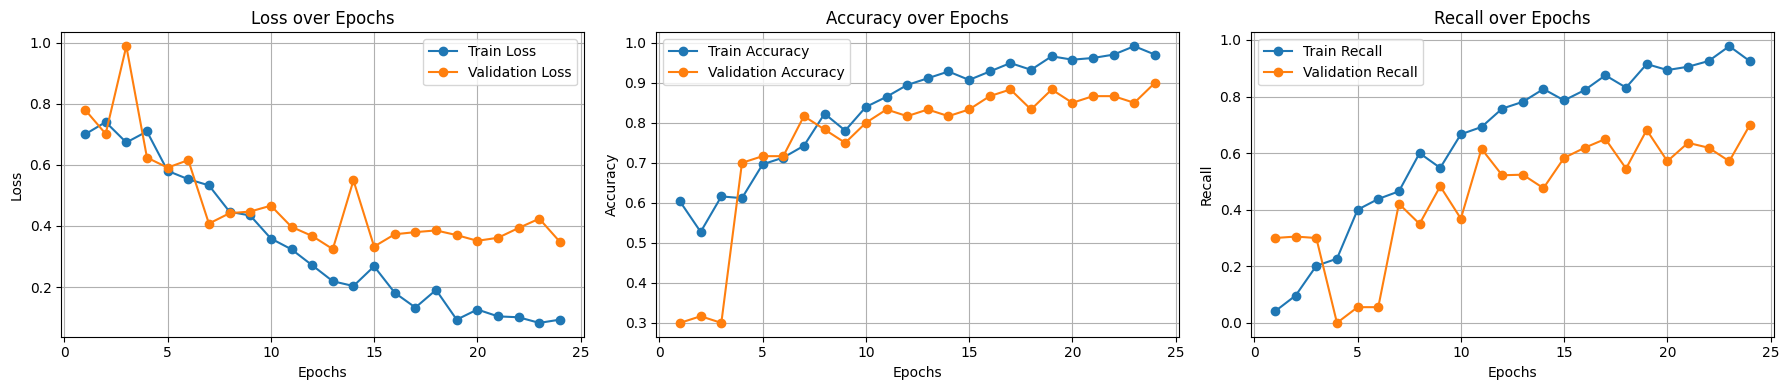

In [197]:
plot_metrics(metric_list)

In [168]:
# Script to write the config file in Jupyter Notebook cell

config_content = """
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='X3D',
        gamma_d=1,
        in_channels=17,
        base_channels=24,
        num_stages=3,
        se_ratio=None,
        use_swish=False,
        stage_blocks=(2, 5, 3),
        spatial_strides=(2, 2, 2)),
    cls_head=dict(
        type='I3DHead',
        in_channels=216,
        num_classes=60,
        dropout=0.5),
    test_cfg=dict(average_clips='prob'))
# model = dict(
#     type='Recognizer3D',
#     backbone=dict(
#         type='C3D',
#         in_channels=17,
#         base_channels=32,
#         num_stages=3,
#         temporal_downsample=False),
#     cls_head=dict(
#         type='I3DHead',
#         in_channels=256,
#         num_classes=2,
#         dropout=0.5),
#     test_cfg=dict(average_clips='prob'))

# lr_new =  lr / (num_gpu * batch_size_per_gpu) (lr=0.4 | 8 gpus)
optimizer=dict(
    type='SGD',
    lr=0.00625,
    momentum=0.9,
    weight_decay=0.0003)

optimizer_config=dict(
    grad_clip=dict(max_norm=40, norm_type=2))

# Learning policy
lr_config=dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr=0)

total_epochs=24

checkpoint_config=dict(
    interval=1)
# Dataset configuration
dataset = dict(
    type='HeatmapVideoDataset',
    root_dir='./Heatmap_Dataset',
    num_frames=64,
    heatmap_type='limb',
    heatmap_size=(17, 56, 56),
    test_size = 0.2,
    batch_size = 32
)

transform = dict(
  type='DropKeypoint',
  drop_prob=0.125
)
"""

# Specify the file path and name
config_file_path = 'model_config.py'

# Write the content to the file
with open(config_file_path, 'w') as f:
    f.write(config_content)

print(f"Config file written to: {config_file_path}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = load_config("model_config.py")
model_cfg = config.model
model = build_model(model_cfg)
model = model.to(device)
print(model)
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model, config)
optimal_batch_size = get_optimal_batch_size(model, input_size=(17, 64, 56, 56), fraction=0.1)
config.dataset['batch_size'] = 8
train_loader, test_loader = load_dataset(config)

Config file written to: model_config.py
Recognizer3D(
  (backbone): X3D(
    (conv1_s): ConvBlock(
      (block): Sequential(
        (0): Conv3d(17, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
      )
    )
    (conv1_t): ConvBlock(
      (block): Sequential(
        (0): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (layer1): Sequential(
      (0): BlockX3D(
        (downsample): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
            (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (conv1): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False

In [169]:
metric_limb = train_model(model, train_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=config.total_epochs, best_model_path='best_model_x3d_limb.pth')

Epoch 1/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3500 - Val acc: 0.7 - Val recall: 0.0
Epoch 1/24, Train Loss: 1.4811, Train Accuracy: 0.5443, Train Recall: 0.0357, Val Loss: 0.6625, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 2/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/24, Train Loss: 0.7057, Train Accuracy: 0.5865, Train Recall: 0.0392, Val Loss: 0.6776, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 3/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/24, Train Loss: 0.6724, Train Accuracy: 0.6076, Train Recall: 0.1226, Val Loss: 0.6089, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 4/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/24, Train Loss: 0.6982, Train Accuracy: 0.5992, Train Recall: 0.2017, Val Loss: 0.6402, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 5/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/24, Train Loss: 0.6713, Train Accuracy: 0.5865, Train Recall: 0.1552, Val Loss: 0.5499, Val Accuracy: 0.6833, Val Recall: 0.0000


Epoch 6/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3667 - Val acc: 0.6833333333333333 - Val recall: 0.05
Epoch 6/24, Train Loss: 0.6283, Train Accuracy: 0.6456, Train Recall: 0.3000, Val Loss: 0.5126, Val Accuracy: 0.6833, Val Recall: 0.0500


Epoch 7/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3763 - Val acc: 0.7 - Val recall: 0.05263157894736842
Epoch 7/24, Train Loss: 0.5624, Train Accuracy: 0.7215, Train Recall: 0.4261, Val Loss: 0.7561, Val Accuracy: 0.7000, Val Recall: 0.0526


Epoch 8/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.6000 - Val acc: 0.8 - Val recall: 0.4
Epoch 8/24, Train Loss: 0.4909, Train Accuracy: 0.7426, Train Recall: 0.4245, Val Loss: 0.5959, Val Accuracy: 0.8000, Val Recall: 0.4000


Epoch 9/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.6600 - Val acc: 0.8 - Val recall: 0.52
Epoch 9/24, Train Loss: 0.4607, Train Accuracy: 0.8017, Train Recall: 0.6017, Val Loss: 0.5175, Val Accuracy: 0.8000, Val Recall: 0.5200


Epoch 10/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/24, Train Loss: 0.3100, Train Accuracy: 0.8819, Train Recall: 0.7358, Val Loss: 0.5362, Val Accuracy: 0.7500, Val Recall: 0.4231


Epoch 11/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/24, Train Loss: 0.3556, Train Accuracy: 0.8481, Train Recall: 0.6571, Val Loss: 0.8027, Val Accuracy: 0.8000, Val Recall: 0.3684


Epoch 12/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/24, Train Loss: 0.2609, Train Accuracy: 0.9072, Train Recall: 0.7778, Val Loss: 0.4491, Val Accuracy: 0.8167, Val Recall: 0.4762


Epoch 13/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7205 - Val acc: 0.85 - Val recall: 0.5909090909090909
Epoch 13/24, Train Loss: 0.2268, Train Accuracy: 0.9030, Train Recall: 0.7788, Val Loss: 0.3528, Val Accuracy: 0.8500, Val Recall: 0.5909


Epoch 14/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/24, Train Loss: 0.1684, Train Accuracy: 0.9283, Train Recall: 0.8300, Val Loss: 0.5086, Val Accuracy: 0.8167, Val Recall: 0.5000


Epoch 15/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/24, Train Loss: 0.2270, Train Accuracy: 0.8945, Train Recall: 0.7525, Val Loss: 0.5118, Val Accuracy: 0.7833, Val Recall: 0.5517


Epoch 16/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7244 - Val acc: 0.8333333333333334 - Val recall: 0.6153846153846154
Epoch 16/24, Train Loss: 0.1553, Train Accuracy: 0.9451, Train Recall: 0.8632, Val Loss: 0.4894, Val Accuracy: 0.8333, Val Recall: 0.6154


Epoch 17/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/24, Train Loss: 0.1780, Train Accuracy: 0.9367, Train Recall: 0.8438, Val Loss: 0.4632, Val Accuracy: 0.8667, Val Recall: 0.5556


Epoch 18/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7333 - Val acc: 0.8666666666666667 - Val recall: 0.6
Epoch 18/24, Train Loss: 0.1592, Train Accuracy: 0.9367, Train Recall: 0.8421, Val Loss: 0.3391, Val Accuracy: 0.8667, Val Recall: 0.6000


Epoch 19/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/24, Train Loss: 0.1025, Train Accuracy: 0.9620, Train Recall: 0.9043, Val Loss: 0.2989, Val Accuracy: 0.8667, Val Recall: 0.6000


Epoch 20/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.7833 - Val acc: 0.9 - Val recall: 0.6666666666666666
Epoch 20/24, Train Loss: 0.0864, Train Accuracy: 0.9747, Train Recall: 0.9348, Val Loss: 0.3800, Val Accuracy: 0.9000, Val Recall: 0.6667


Epoch 21/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/24, Train Loss: 0.0742, Train Accuracy: 0.9747, Train Recall: 0.9355, Val Loss: 0.3129, Val Accuracy: 0.8500, Val Recall: 0.5714


Epoch 22/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/24, Train Loss: 0.0829, Train Accuracy: 0.9831, Train Recall: 0.9560, Val Loss: 0.3560, Val Accuracy: 0.8333, Val Recall: 0.5238


Epoch 23/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/24, Train Loss: 0.0783, Train Accuracy: 0.9873, Train Recall: 0.9670, Val Loss: 0.3001, Val Accuracy: 0.8500, Val Recall: 0.5714


Epoch 24/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/24, Train Loss: 0.1114, Train Accuracy: 0.9705, Train Recall: 0.9247, Val Loss: 0.3256, Val Accuracy: 0.8500, Val Recall: 0.5714


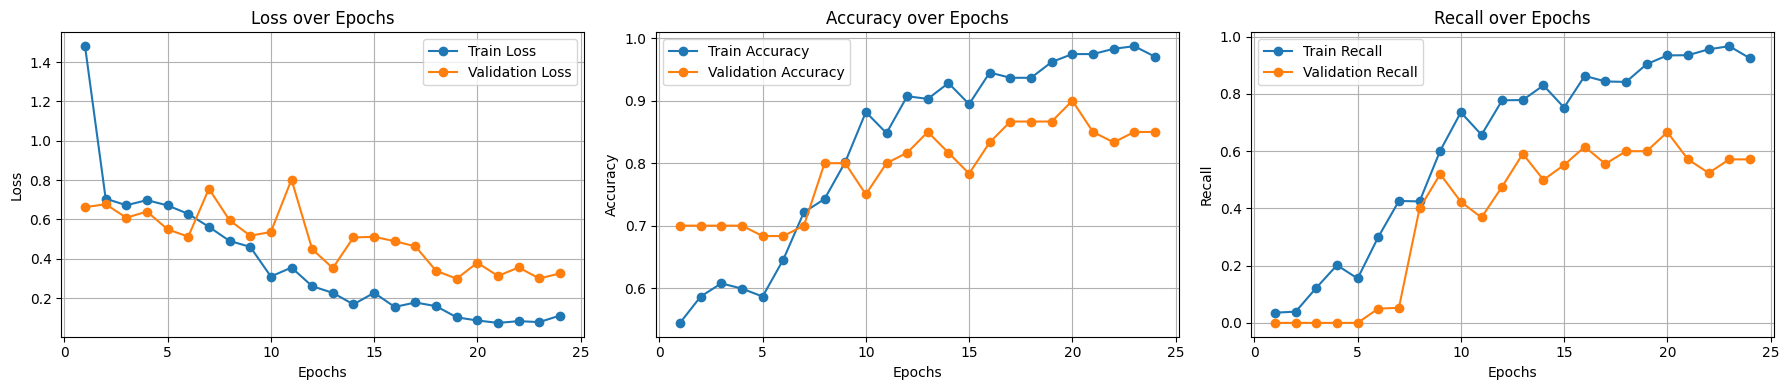

In [170]:
plot_metrics(metric_limb)

In [198]:
# Script to write the config file in Jupyter Notebook cell

config_content = """
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='X3D',
        gamma_d=1,
        in_channels=17,
        base_channels=24,
        num_stages=3,
        se_ratio=None,
        use_swish=False,
        stage_blocks=(2, 5, 3),
        spatial_strides=(2, 2, 2)),
    cls_head=dict(
        type='I3DHead',
        in_channels=216,
        num_classes=2,
        dropout=0.5),
    test_cfg=dict(average_clips='prob'))
# model = dict(
#     type='Recognizer3D',
#     backbone=dict(
#         type='C3D',
#         in_channels=17,
#         base_channels=32,
#         num_stages=3,
#         temporal_downsample=False),
#     cls_head=dict(
#         type='I3DHead',
#         in_channels=256,
#         num_classes=2,
#         dropout=0.5),
#     test_cfg=dict(average_clips='prob'))

# lr_new =  lr / (num_gpu * batch_size_per_gpu) (lr=0.4 | 8 gpus)
optimizer=dict(
    type='SGD',
    lr=0.00625,
    momentum=0.9,
    weight_decay=0.0003)

optimizer_config=dict(
    grad_clip=dict(max_norm=40, norm_type=2))

# Learning policy
lr_config=dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr=0)

total_epochs=24

checkpoint_config=dict(
    interval=1)
# Dataset configuration
dataset = dict(
    type='HeatmapVideoDataset',
    root_dir='./Heatmap_Dataset',
    num_frames=64,
    heatmap_type='both',
    heatmap_size=(17, 56, 56),
    test_size = 0.2,
    batch_size = 32
)

transform = dict(
  type='DropKeypoint',
  drop_prob=0.125
)
"""

# Specify the file path and name
config_file_path = 'model_config.py'

# Write the content to the file
with open(config_file_path, 'w') as f:
    f.write(config_content)

print(f"Config file written to: {config_file_path}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = load_config("model_config.py")
model_cfg = config.model
model = build_model(model_cfg)
model = model.to(device)
print(model)
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model, config)
optimal_batch_size = get_optimal_batch_size(model, input_size=(17, 64, 56, 56), fraction=0.1)
config.dataset['batch_size'] = 8
train_loader, test_loader = load_dataset(config)

Config file written to: model_config.py
Recognizer3D(
  (backbone): X3D(
    (conv1_s): ConvBlock(
      (block): Sequential(
        (0): Conv3d(17, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
      )
    )
    (conv1_t): ConvBlock(
      (block): Sequential(
        (0): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (layer1): Sequential(
      (0): BlockX3D(
        (downsample): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
            (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (conv1): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False

In [ ]:
metric_both = train_model(model, train_loader, test_loader, optimizer, lr_scheduler, device, num_epochs=config.total_epochs, best_model_path='best_model_x3d_both.pth')

Epoch 1/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.3500 - Val acc: 0.7 - Val recall: 0.0
Epoch 1/24, Train Loss: 0.6913, Train Accuracy: 0.5738, Train Recall: 0.0472, Val Loss: 0.6191, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 2/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/24, Train Loss: 0.6862, Train Accuracy: 0.6034, Train Recall: 0.1132, Val Loss: 0.6771, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 3/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/24, Train Loss: 0.6770, Train Accuracy: 0.6160, Train Recall: 0.1165, Val Loss: 0.6070, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 4/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/24, Train Loss: 0.6847, Train Accuracy: 0.5949, Train Recall: 0.1795, Val Loss: 0.5764, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 5/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/24, Train Loss: 0.6835, Train Accuracy: 0.6371, Train Recall: 0.1569, Val Loss: 0.5413, Val Accuracy: 0.7000, Val Recall: 0.0000


Epoch 6/24:   0%|          | 0/30 [00:00<?, ?it/s]

Saved best model with validation fitness score: 0.6786 - Val acc: 0.8333333333333334 - Val recall: 0.5238095238095238
Epoch 6/24, Train Loss: 0.6735, Train Accuracy: 0.5992, Train Recall: 0.2339, Val Loss: 0.4557, Val Accuracy: 0.8333, Val Recall: 0.5238


Epoch 7/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/24, Train Loss: 0.5389, Train Accuracy: 0.7342, Train Recall: 0.4425, Val Loss: 0.4126, Val Accuracy: 0.8167, Val Recall: 0.4500


Epoch 8/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/24, Train Loss: 0.4529, Train Accuracy: 0.8101, Train Recall: 0.5714, Val Loss: 0.5737, Val Accuracy: 0.7167, Val Recall: 0.5143


Epoch 9/24:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/24, Train Loss: 0.4515, Train Accuracy: 0.7932, Train Recall: 0.5586, Val Loss: 0.4852, Val Accuracy: 0.7500, Val Recall: 0.2105


Epoch 10/24:   0%|          | 0/30 [00:00<?, ?it/s]

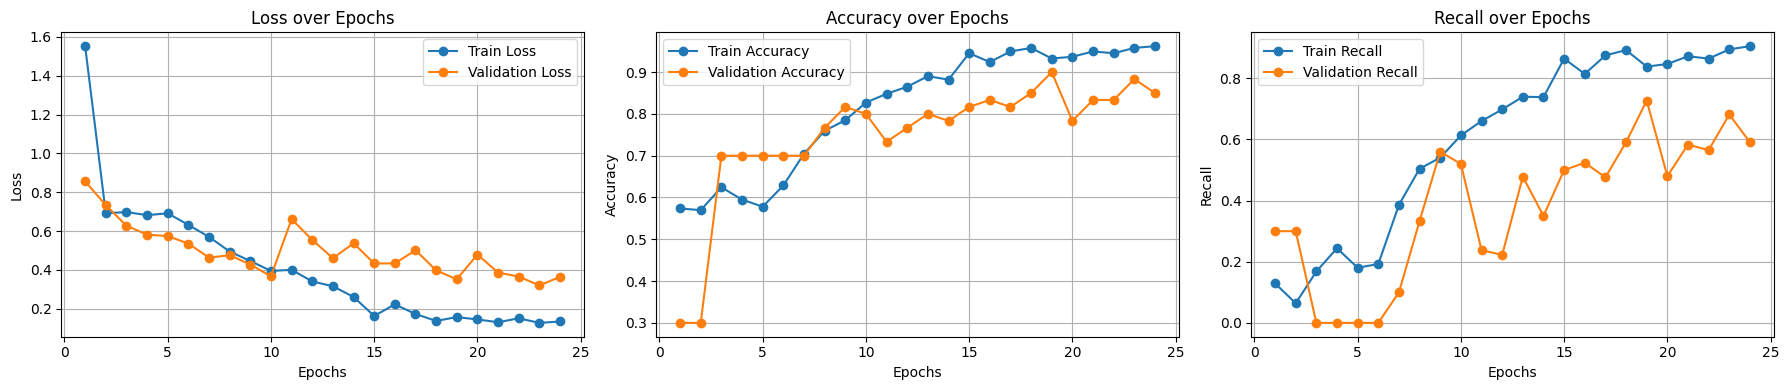

In [173]:
plot_metrics(metric_both)

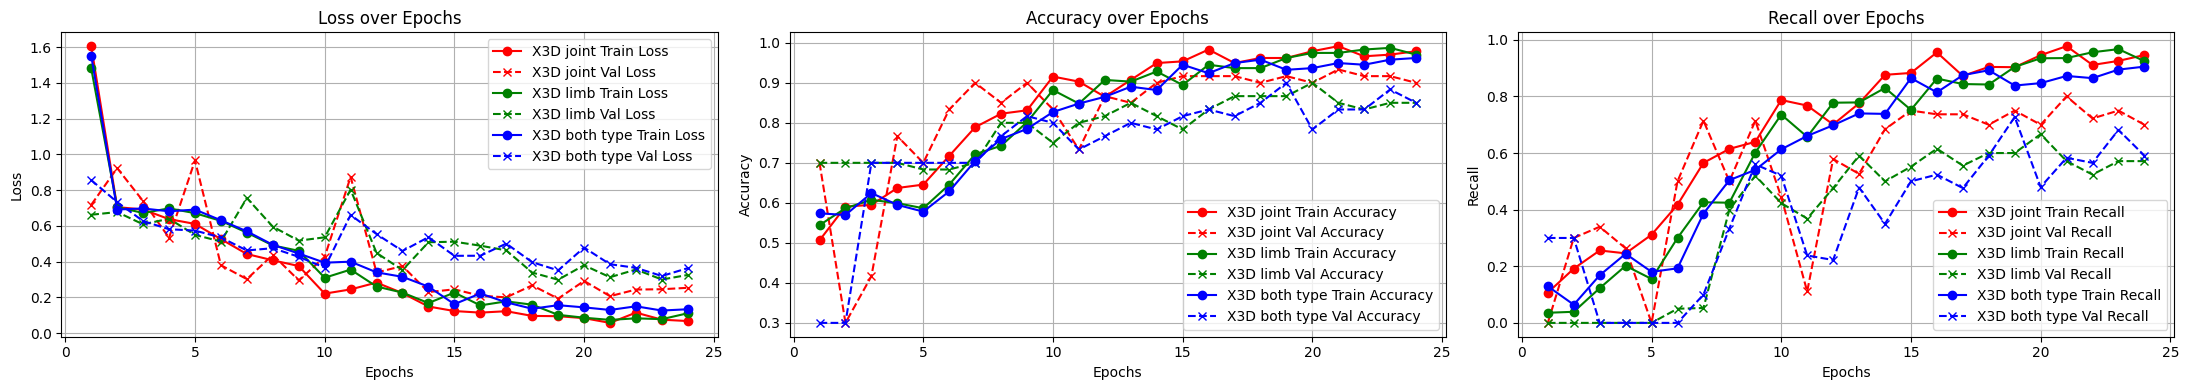

In [186]:
colors = ['r', 'g', 'b']  # Add more colors if needed
metrics_list = [metric_list,metric_limb,metric_both]

def plot_multiple_metrics(metrics_list):
    num_models = len(metrics_list)
    epochs = range(1, len(metrics_list[0]) + 1)
    name = ['joint','limb','both type']
    # Create subplots
    plt.figure(figsize=(22, 4))

    # Plot Loss
    plt.subplot(1, 3, 1)
    for i, metrics in enumerate(metrics_list):
        train_losses = [m['train_loss'] for m in metrics]
        val_losses = [m['val_loss'] for m in metrics]
        plt.plot(epochs, train_losses, label=f'X3D {name[i]} Train Loss', marker='o', color=colors[i])
        plt.plot(epochs, val_losses, label=f'X3D {name[i]} Val Loss', marker='x', linestyle='--', color=colors[i])
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    for i, metrics in enumerate(metrics_list):
        train_accuracies = [m['train_accuracy'] for m in metrics]
        val_accuracies = [m['val_accuracy'] for m in metrics]
        plt.plot(epochs, train_accuracies, label=f'X3D {name[i]} Train Accuracy', marker='o', color=colors[i])
        plt.plot(epochs, val_accuracies, label=f'X3D {name[i]} Val Accuracy', marker='x', linestyle='--', color=colors[i])
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot Recall
    plt.subplot(1, 3, 3)
    for i, metrics in enumerate(metrics_list):
        train_recalls = [m['train_recall'] for m in metrics]
        val_recalls = [m['val_recall'] for m in metrics]
        plt.plot(epochs, train_recalls, label=f'X3D {name[i]} Train Recall', marker='o', color=colors[i])
        plt.plot(epochs, val_recalls, label=f'X3D {name[i]} Val Recall', marker='x', linestyle='--', color=colors[i])
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with the metrics list
plot_multiple_metrics(metrics_list)

In [174]:
import cv2
def load_video_or_heatmap_stream(input_path, heatmap_npz=False, heatmap_type = None, T=32):
    """
    Load a video or a stream of heatmap tensors from the specified input path.

    Args:
        input_path (str): Path to the video file or heatmap folder.
        heatmap_mode (bool): If True, load the input as a heatmap tensor instead of video.

    Returns:
        torch.Tensor: Tensor containing the video or heatmap stream in (Total_frames, C, H, W) format.
    """
    if heatmap_npz:
        # Load heatmap tensor assuming it's a preprocessed .npy or .npz file
        # video = torch.tensor(np.load(input_path)).float()  # Shape: (Total_frames, C, H, W)
        video = []
        for file_npz in os.listdir(input_path):
            if (heatmap_type == 'joint' or heatmap_type == 'both') and file_npz.startswith('j_frame') and file_npz.endswith('.npz'):
                frame = sparse.load_npz(os.path.join(input_path,file_npz))
                frame = frame.todense()
                video.append(frame)
            if (heatmap_type == 'limb' or heatmap_type == 'both') and file_npz.startswith('l_frame') and file_npz.endswith('.npz'):
                frame = sparse.load_npz(os.path.join(input_path,file_npz))
                frame = frame.todense()
                video.append(frame)
        video = torch.tensor(np.stack(video), dtype=torch.float32)
        video = uniform_sample_clip(video, T)
        video = video.permute(1,0,2,3)
        return video
    else:
        # Load video file
        cap = cv2.VideoCapture(input_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB and add to frame list
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        # Convert to torch tensor with shape (Total_frames, C, H, W)
        video = torch.tensor(np.stack(frames)).permute(0, 3, 1, 2).float()  # Convert to (Total_frames, C, H, W)
    return video

def predict(model, input_path, T, heatmap_npz=False,heatmap_type=None):
    """
    Load video/heatmap stream, perform uniform sampling, and predict using the model.

    Args:
        model (torch.nn.Module): Trained model for prediction.
        input_path (str): Path to the input video or heatmap file.
        T (int): Number of frames to sample.
        heatmap_mode (bool): If True, treat the input as a heatmap stream instead of video.

    Returns:
        torch.Tensor: The model's predicted output.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the video or heatmap stream
    video = load_video_or_heatmap_stream(input_path, heatmap_npz=heatmap_npz, heatmap_type= heatmap_type, T = T).to(device)
    # Set the model to evaluation mode
    model.eval()

    # Perform prediction on sampled frames
    with torch.no_grad():
        prediction = model(video.unsqueeze(0))  # Add batch dimension: (1, T, C, H, W)

    return prediction

In [175]:
# input_video_path = "./heatmap_video.mp4"  # Or the heatmap file if using heatmaps
input_video_path = './Heatmap_Dataset/shop_lifter_16/id_1'
T = 64  # Number of frames to sample
heatmap_npz = True  # Set True if using heatmap input
heatmap_type = 'joint'

# Perform prediction
predicted_output = predict(model, input_video_path, T, heatmap_npz=heatmap_npz,heatmap_type=heatmap_type)
_, pred_label = torch.max(predicted_output.data, 1)
print('Prediction:',pred_label.cpu().numpy()[0])

Prediction: 1


In [187]:
# Define the directory containing the heatmap files
input_video_path = './Heatmap_Dataset/'
T = 64  # Number of frames to sample
heatmap_npz = True  # Set True if using heatmap input
heatmap_type = 'joint'

# Initialize a list to store all heatmap file paths
heatmap_files = []

# Traverse the directory and its subdirectories to find .npz files
for dirpath, _, files in os.walk(input_video_path):
    for file in files:
        if file.endswith('.npz'):  # Adjust extension as needed
            # Append the parent directory name (not the full file path)
            heatmap_files.append(dirpath)
            break  # Break out of the loop after finding the first .npz file

# Check if there are any files to process
if not heatmap_files:
    print("No heatmap files found in the specified directory.")
else:
    for heatmap_file_path in heatmap_files:
        # Perform prediction for the current heatmap file
        predicted_output = predict(model, heatmap_file_path, T, heatmap_npz=heatmap_npz, heatmap_type=heatmap_type)

        # Get the predicted label and confidence score
        _, pred_label = torch.max(predicted_output.data, 1)
        confidence_score = torch.nn.functional.softmax(predicted_output, dim=1)  # Calculate confidence scores
        pred_confidence = confidence_score.max().item()  # Get the maximum confidence score
        pred = pred_label.cpu().numpy()[0]

        # Extract label based on the filename (modify logic if needed)
        label = 0 if '_n_' in heatmap_file_path.split("/")[-2] else 1

        # Print prediction, label, and confidence score
        print(f'Prediction for Parent Directory: "{heatmap_file_path.split("/")[-2]}"\n'
              f' - Predicted Class: {pred} - Actual Label: {label} - Confidence Score: {pred_confidence:.4f}' )


Prediction for Parent Directory: "shop_lifter_n_176"
 - Predicted Class: 0 - Actual Label: 0 - Confidence Score: 0.9907
Prediction for Parent Directory: "shop_lifter_n_5"
 - Predicted Class: 0 - Actual Label: 0 - Confidence Score: 0.9929
Prediction for Parent Directory: "shop_lifter_n_6"
 - Predicted Class: 0 - Actual Label: 0 - Confidence Score: 0.5486
Prediction for Parent Directory: "shop_lifter_7"
 - Predicted Class: 1 - Actual Label: 1 - Confidence Score: 0.9452
Prediction for Parent Directory: "shop_lifter_86"
 - Predicted Class: 1 - Actual Label: 1 - Confidence Score: 0.9912
Prediction for Parent Directory: "shop_lifter_n_214_flipped"
 - Predicted Class: 0 - Actual Label: 0 - Confidence Score: 0.9679
Prediction for Parent Directory: "shop_lifter_90"
 - Predicted Class: 1 - Actual Label: 1 - Confidence Score: 0.9714
Prediction for Parent Directory: "shop_lifter_n_70"
 - Predicted Class: 1 - Actual Label: 0 - Confidence Score: 0.9915
Prediction for Parent Directory: "shop_lifter_4

KeyboardInterrupt: 

In [188]:
# Script to write the config file in Jupyter Notebook cell

config_content = """
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='X3D',
        gamma_d=1,
        in_channels=17,
        base_channels=24,
        num_stages=3,
        se_ratio=None,
        use_swish=False,
        stage_blocks=(2, 5, 3),
        spatial_strides=(2, 2, 2)),
    cls_head=dict(
        type='I3DHead',
        in_channels=216,
        num_classes=2,
        dropout=0.5),
    test_cfg=dict(average_clips='prob'))
# model = dict(
#     type='Recognizer3D',
#     backbone=dict(
#         type='C3D',
#         in_channels=17,
#         base_channels=32,
#         num_stages=3,
#         temporal_downsample=False),
#     cls_head=dict(
#         type='I3DHead',
#         in_channels=256,
#         num_classes=2,
#         dropout=0.5),
#     test_cfg=dict(average_clips='prob'))

# lr_new =  lr / (num_gpu * batch_size_per_gpu) (lr=0.4 | 8 gpus)
optimizer=dict(
    type='SGD',
    lr=0.00625,
    momentum=0.9,
    weight_decay=0.0003)

optimizer_config=dict(
    grad_clip=dict(max_norm=40, norm_type=2))

# Learning policy
lr_config=dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr=0)

total_epochs=24

checkpoint_config=dict(
    interval=1)
# Dataset configuration
dataset = dict(
    type='HeatmapVideoDataset',
    root_dir='./Heatmap_Dataset',
    num_frames=64,
    heatmap_type='both',
    heatmap_size=(17, 56, 56),
    test_size = 0.2,
    batch_size = 32
)

transform = dict(
  type='DropKeypoint',
  drop_prob=0.125
)
"""

# Specify the file path and name
config_file_path = 'model_config.py'

# Write the content to the file
with open(config_file_path, 'w') as f:
    f.write(config_content)

print(f"Config file written to: {config_file_path}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = load_config("model_config.py")
model_cfg = config.model
model = build_model(model_cfg)
# model = model.to(device)
print(model)
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model, config)
optimal_batch_size = get_optimal_batch_size(model, input_size=(17, 64, 56, 56), fraction=0.1)
config.dataset['batch_size'] = 8
train_loader, test_loader = load_dataset(config)

Config file written to: model_config.py
Recognizer3D(
  (backbone): X3D(
    (conv1_s): ConvBlock(
      (block): Sequential(
        (0): Conv3d(17, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
      )
    )
    (conv1_t): ConvBlock(
      (block): Sequential(
        (0): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (layer1): Sequential(
      (0): BlockX3D(
        (downsample): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
            (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (conv1): ConvBlock(
          (block): Sequential(
            (0): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False